In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
#from IPython.core.display import HTML
#css_file = './custom.css'
#HTML(open(css_file, "r").read())

Here we attempt solve following equation:

\begin{equation}
\partial_a\psi = i\kappa\frac{\nabla^2\psi}{a^3 \mathcal{H}}-i\frac{V\psi}{a^2\mathcal{H}}
\end{equation}
  
  where
  \begin{equation}
  \nabla^2V = \frac{1}{2\kappa}\left(|\psi|^2 -<|\psi|^2> \right)
  \end{equation}
with
\begin{equation}
\mathcal{H} = \sqrt{\Omega a^{-3} + (1-\Omega)}
\end{equation}

$a$ is scale-factor of the Universe and is monotonically increasing with physical time and is used in this code as 
time variable.
    
    
    
    
    

In [2]:
#from GPE import GPE_scalar_field
from GPE import ImEx
import time

In [44]:
#3-d 
'''
# Higueras (17)
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imC = np.array([2.0/11,289.0/462.0,751.0/924.0])

exC= np.array([0.0,5.0/6.0,11.0/12.0])
imx = ImEx(3,Ahat,A,bhat,b,imC,exC)
'''
########################### scheme_Car4_3_6L_2_SA   #####################################

imA = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],
[0.25,0.25,0.0,0.0,0.0,0.0],
[8611.0/62500.0,-1743.0/31250,0.25,0.0,0.0,0.0],
[5012029.0/34652500.0,-654441.0/2922500.0,174375.0/388108.0,0.25,0.0,0.0],
[15267082809.0/155376265600.0,-71443401.0/120774400.0, 730878875.0/902184768.0, 2285395.0/8070912.0,0.25,0.0],
[82889.0/524892.0, 0.0, 15625.0/83664.0, 69875.0/102672.0, -2260.0/8211.0, 0.25]])

exA = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],
[0.5,0.0,0.0,0.0,0.0,0.0],
[13861.0/62500,  6889.0/62500.0,0.0,0.0,0.0,0.0],
[-116923316275.0/2393684061468.0, -2731218467317.0/15368042101831.0, 9408046702089.0/11113171139209.0, 0.0,0.0,0.0],
[-451086348788.0/2902428689909.0, -2682348792572.0/7519795681897.0, 12662868775082.0/11960479115383.0,3355817975965.0/11060851509271.0,0.0,0.0],
[647845179188.0/3216320057751.0,73281519250.0/8382639484533.0, 552539513391.0/3454668386233.0, 3354512671639.0/8306763924573.0,4040.0/17871.0,0.0]])

imb = np.array([82889.0/524892.0, 0.0, 15625.0/83664.0, 69875.0/102672.0,-2260.0/8211.0,0.25])
exb = np.array([82889.0/524892.0, 0.0, 15625.0/83664.0, 69875.0/102672.0,-2260.0/8211.0,0.25])

imC = np.array([0.0,0.5,83.0/250.0,31.0/50.0, 17.0/20.0,1.0])
exC = np.array([0.0,0.5,83.0/250.0,31.0/50.0, 17.0/20.0,1.0])


imx = ImEx(6,imA,exA,imb,exb,imC,exC)

imx.cal_reg_of_stab()

def load_psi_hdf5(file_name,n,use_zeldo=1):
    f = h5.File(file_name,"r")
    keys = list(f.keys())
    if use_zeldo:
        psi = f["psi_zeldo"]
    else:
        psi = f["psi"]
        
    psi = psi[:,0]+1j*psi[:,1]
    psi = np.reshape(psi,(n,n,n))
        
    print("Psi shape",psi.shape,psi.dtype)
    
    return psi


def Hfunc(a,omega_m0,a0=1.0):
    return( np.sqrt(omega_m0*(a0/a)*(a0/a)*(a0/a) + (1.0 - omega_m0))    )


def rhs_f(u,xi2,kppa,a,da,s,omega_m0):
    
    u2 = np.square(np.abs(u))
    vrhs = 1.5*omega_m0*(u2/np.mean(u2) -1.0)/kppa
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = (np.fft.ifftn(vrhsft,vrhsft.shape));
    
    
    ak = a+imx.ex_C[s]*da
    H = Hfunc(ak,omega_m0)
    
    
    return (-1j*v*u/(ak*ak*H))

def im_rhs(psi_ft,xi2,kppa,a,da,s,omega_m0):
   
    psi_ft = -psi_ft*(xi2)
    ak = a+imx.im_C[s]*da
    H = Hfunc(ak,omega_m0)
    return(1j*0.5*kppa*np.fft.ifftn(psi_ft,psi_ft.shape)/(ak*ak*ak*H))

    #return(0.0)

def calc_max_eig(u,xi2,kppa,a,omega_m0):
    
    u2 = np.square(np.abs(u))
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = (np.fft.ifftn(vrhsft,vrhsft.shape));
    H= Hfunc(a,omega_m0)
    mx = np.max(np.abs(v.real)/(a*a*H))
    
    return (mx)



class energy_constraint:
    def __init__(self):
        
        self.E=np.zeros([3])
        self.W=np.zeros([3])
        self.K=np.zeros([3])
        
        self.E_exp = 0.0
        self.E_ini = 0.0
        
        
    def calc_energy(self,u,xi3,xi2,kppa,a,da,n_cntr):
        ft_psi = np.fft.fftn(u,u.shape)
        ft_psi = 1j*xi3*ft_psi

        psi_x = np.fft.ifftn(ft_psi,ft_psi.shape[1:],axes=(1,2,3))
        psi_x = np.square(np.abs(psi_x)).sum(axis=0)

        Kv = 0.5*kppa*psi_x.sum()/(a*a)
     
    
        u2 = np.square(np.abs(u))
        vrhs = 0.5*(u2-np.mean(u2))/kppa
        vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
        vrhsft[0,0,0] = 0.0+0.0*1j
        v = (np.fft.ifftn(vrhsft,vrhsft.shape)).real;
    
        Wv = 0.5*np.sum(v*u2)/a
        
        Ev = Kv+Wv
        
       # print("Wv",Wv/Ev,"Kv",Kv/Ev)
        

    
        if(n_cntr==0):
            
            self.E[0] = Kv+Wv
            self.K[0] = Kv
            self.W[0] = Wv
            
            self.E_exp = 0.0
            self.E_ini = Ev
            dlta = 0.0
            dlta_intg=0.0
            
        if(n_cntr==1):
        
            self.E[1] = Kv+Wv
            self.K[1] = Kv
            self.W[1] = Wv
            
            dlta = 0.0
            
            
            term_l = (2.0*self.K[0]+self.W[0])/(a)
            term_r = (2.0*self.K[1]+self.W[1])/(a)
            
            print("EEE",self.E_exp/(self.E[0]-Ev))
            
            self.E_exp+=0.5*da*(term_l+term_r)
            
            dlta_intg = (self.E_exp+Ev)/self.E_ini -1.0
            
            print("EEE",self.E_exp/(self.E[0]-Ev))

            
        
            
        
            
        if(n_cntr>1):   
            
            self.E[2] = Ev
            
            self.K[2] = Kv
            self.W[2] = Wv
            
            term_l = (2.0*self.K[1]+self.W[1])/(a-da)
            term_r = (2.0*self.K[2]+self.W[2])/(a)
            
            self.E_exp+=0.5*da*(term_l+term_r)
            
            #print("EEE",n_cntr,0.5*da*(term_l+term_r)/(self.E[1]-Ev))
            
            dlta_intg = (self.E_exp+Ev)/self.E_ini -1.0
            
            dE_da = (self.E[2]-self.E[0])/(2.0*da)
            rhs = -(2.0*self.K[1]+self.W[1])/(a-da)
            #rhs = self.W[1]/(a-da)
            
            dlta = dE_da/rhs-1.0
            
            
            self.E[0] = self.E[1]
            self.K[0] = self.K[1]
            self.W[0] = self.W[1]
            
            self.E[1] = self.E[2]
            self.K[1] = self.K[2]
            self.W[1] = self.W[2]
            
            dlta_intg = (self.E_exp+Ev)/self.E_ini -1.0
            
            if(n_cntr==30):
                self.E_ini = (Ev)
                self.E_exp = 0.0
            
        #print("E_tot",self.E_exp+Ev,self.E_exp,Ev)
            
        return dlta,dlta_intg,Ev,Kv,Wv,self.E_exp

def sol_err(psi,t,nx,T,max_err=-1.0):

    sol = np.exp(-1j*(2.0*t*np.pi/T))*np.sin(2.0*np.pi*nx)
    #print("sol shape",sol.shape,"psi.shape",psi.shape)
    err = np.square(np.abs(sol-psi).flatten()).sum()
    err = err/(np.square(np.abs(sol).flatten()).sum())
    if(err>max_err):
        max_err = err
    return(max_err)



def solve_fdm_example(N,da):
    L = 1.0
    
    x = np.arange(-N/2,N/2)*(L/N)
    xv,yv,zv = np.meshgrid(x,x,x)
    xi = np.fft.fftfreq(N)*N*2*np.pi/L
    #xix,xiy,xiz = np.meshgrid(xi,xi,xi)
    #xi3 = np.array([xix,xiy,xiz])
    
    c_unit = 2.99
    hbar_unit = 6.582
    pc_unit = 3.086
    h = 0.67
    m_alpha = 0.175
    omega_m0 = 0.3
    ai = 0.0078125
    
    kppa = c_unit*c_unit*hbar_unit*h*0.00001/(m_alpha*pc_unit)
    
   
   
    psi_ini = load_psi_hdf5("/Users/rajvanmp/station_X/pyGP_fields/test_fdm_dt/dc_128_dc_theta_psi_zeldo.hdf5",N,1)
   
    
   
    #psl = np.reshape(np.genfromtxt("test_initial1.txt",usecols=(4,5)),(N,N,N,2))
    #psi_ini = (psl[:,:,:,0]/100.0)+1j*(psl[:,:,:,1]/100.0)
    psi_ini = psi_ini[30,53,:]
    print(psi_ini.shape)
    
    

   
    print(type(psi_ini),psi_ini.shape,psi_ini.dtype)
    amax = 1.0

    

    num_plots = 50
    nplt = np.floor(((amax-ai)/num_plots)/da)
    if(nplt<1):
        nplt  = 1
    nmax = int(round((amax-ai)/da))
    print(nplt,"nmax",nmax)

    frames = [psi_ini.copy()]
    aa = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    eng_err_l=[]
    
    E = np.zeros([4,nmax])
    

    
    
    #psi = GPE_scalar_field(3,N,im_rhs,rhs_f,imx,psi_ini)
    energy_cond = energy_constraint()
    
    psi = 1.0*psi_ini
    xi2 = (xi*xi)
    lmbda_s = (0.5*kppa*xi2)
    
    u2 = np.square(np.abs(psi_ini))
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    dlt = (u2-np.mean(u2))/(3.0*omega_m0)
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0] = 0.0+0.0*1j
    V = (np.fft.ifftn(vrhsft,vrhsft.shape))/(ai*ai*Hfunc(ai,omega_m0));
    
    mass_ini = np.sum(np.square(np.abs(psi)))
    
    ft_psi = np.fft.fftn(psi,psi.shape)
    ft_mass_ini= np.sum(np.square(np.abs(ft_psi)))
    
    print("MASS INI is ",mass_ini,ft_mass_ini)
    
    max_err = -1.0
    a = ai
    start_time = time.time()    
    for n in range(nmax):
        
        #eng_dlta,eng_dlta_intg,Ev,Kv,Wv,E_exp = energy_cond.calc_energy(psi,xi3,xi2,kppa,a,da,n)
        
        #E[0,n]=Ev
        #E[1,n]=Kv
        #E[2,n]=Wv
        #E[3,n]=E_exp
        
        styH = np.sqrt(omega_m0*np.power(1.0/a,3.0) + (1.0-omega_m0))
        
        fac = 0.5*1j*da*V/(a*a*styH)
        psi = np.exp(-fac)*psi
        
        ft_psi = np.fft.fftn(psi,psi.shape)
        #print("FT B",np.sum(np.square(np.abs(ft_psi))))
        fac = 0.5*1j*kppa*da*xi2/(a*a*a*styH)
        ft_psi = np.exp(-fac)*ft_psi
        #print("FT A",np.sum(np.square(np.abs(ft_psi))))
        psi = np.fft.ifftn(ft_psi,ft_psi.shape)
        
        V_rhs = (0.5/kppa)*(np.square(np.abs(psi))-np.mean(np.square(np.abs(psi))))
        ft_V = np.fft.fftn(V_rhs,V_rhs.shape)/xi2
        ft_V[0] = 0.0+0.0*1j
        V = np.fft.ifftn(-ft_V,ft_V.shape)
        
        fac = 0.5*1j*da*V/(a*a*styH)
        psi = np.exp(-fac)*psi
        
        
        a = ai+(n+1)*da
        
        
        #print(a,da,"eng_dlta",eng_dlta,eng_dlta_intg,Ev)
        #max_egn = calc_max_eig(psi,xi2,kppa,a,omega_m0)
        #if((max_egn*da)>imx.r_of_stb.imag):
        #    print("maxeg*dt @ n",max_egn*da,n,k,imx.r_of_stb.imag)
        #   da  = 0.9*(imx.r_of_stb.imag/max_egn)
        
        
        
        if np.mod(n,nplt) == 0:
            frames.append(psi)
            aa.append(a)
           # err = sol_err(psi.psi,t,nx,T,max_err)
          #  err_l.append(err)
        
            
            
            mass = np.sum(np.square(np.abs(psi)))#psi.calc_mass()
            mass_err = np.abs((mass-mass_ini))/mass_ini
            
            #print(np.abs(mass-mass_ini)/mass_ini)
            
            mass_l.append(mass)
            mass_err_l.append(mass_err)
            #eng_err_l.append([eng_dlta,eng_dlta_intg])
            print("a=",a,da)#,eng_dlta,eng_dlta_intg)
           


   # err =  sol_err(psi.psi,t,nx,T,max_err)
  #  err_l.append(err)
            
    mass = np.sum(np.square(np.abs(psi)))
    mass_err = np.abs((mass-mass_ini))/mass_ini
    #eng_dlta = energy_cond.calc_energy(psi,xi3,xi2,kppa,a,da,n)
    
    ft_psi = np.fft.fftn(psi,psi.shape)
    ft_mass_last= np.sum(np.square(np.abs(ft_psi)))
    
    print("MASS LAST is ",mass,ft_mass_last)
            
    mass_l.append(mass)
    mass_err_l.append(mass_err)
       
    return frames,mass_l,mass_err_l,(time.time() - start_time)#,eng_err_l,E,

In [45]:
da = 0.0001
er = []
dal = []
for i in range(1):
        print(i)
        frames,mass_l,mass_err_l,comp_time = solve_fdm_example(128,da)
        
        er.append(np.max(np.abs(mass_err_l)))
        dal.append(da)
        
        da = 0.5*da
        
        

#er = np.array(er)
#dal = np.array(dal)

#ldt = np.log(dal)
#lerrmx = np.log(er)
#print(ldt)

#z= np.polyfit(ldt,lerrmx,1)

#print(z)

0
Psi shape (128, 128, 128) complex128
(128,)
<class 'numpy.ndarray'> (128,) complex128
198.0 nmax 9922
MASS INI is  115.87800265568035 14832.384339927085
a= 0.0079125 0.0001
a= 0.0277125 0.0001
a= 0.0475125 0.0001
a= 0.0673125 0.0001
a= 0.08711250000000001 0.0001
a= 0.10691250000000001 0.0001
a= 0.1267125 0.0001
a= 0.14651250000000002 0.0001
a= 0.1663125 0.0001
a= 0.18611250000000001 0.0001
a= 0.2059125 0.0001
a= 0.2257125 0.0001
a= 0.24551250000000002 0.0001
a= 0.2653125 0.0001
a= 0.2851125 0.0001
a= 0.30491250000000003 0.0001
a= 0.3247125 0.0001
a= 0.3445125 0.0001
a= 0.36431250000000004 0.0001
a= 0.3841125 0.0001
a= 0.4039125 0.0001
a= 0.42371250000000005 0.0001
a= 0.44351250000000003 0.0001
a= 0.4633125 0.0001


/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_48581/2928896665.py:290: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_48581/2928896665.py:290: RuntimeWarning: invalid value encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_48581/2928896665.py:326: RuntimeWarning: divide by zero encountered in divide
  ft_V = np.fft.fftn(V_rhs,V_rhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_48581/2928896665.py:326: RuntimeWarning: invalid value encountered in divide
  ft_V = np.fft.fftn(V_rhs,V_rhs.shape)/xi2


a= 0.4831125 0.0001
a= 0.5029125000000001 0.0001
a= 0.5227125 0.0001
a= 0.5425125000000001 0.0001
a= 0.5623125 0.0001
a= 0.5821125 0.0001
a= 0.6019125000000001 0.0001
a= 0.6217125 0.0001
a= 0.6415125 0.0001
a= 0.6613125000000001 0.0001
a= 0.6811125 0.0001
a= 0.7009125 0.0001
a= 0.7207125000000001 0.0001
a= 0.7405125 0.0001
a= 0.7603125000000001 0.0001
a= 0.7801125 0.0001
a= 0.7999125 0.0001
a= 0.8197125000000001 0.0001
a= 0.8395125 0.0001
a= 0.8593125 0.0001
a= 0.8791125000000001 0.0001
a= 0.8989125 0.0001
a= 0.9187125 0.0001
a= 0.9385125000000001 0.0001
a= 0.9583125 0.0001
a= 0.9781125 0.0001
a= 0.9979125000000001 0.0001
MASS LAST is  115.87800265570147 14832.38433992979


In [14]:
with open('split_psi_1d_m4.npy', 'wb') as f:
    np.save(f,frames[-1])

In [46]:
psi_i=frames[0]
psi_f=frames[-1]

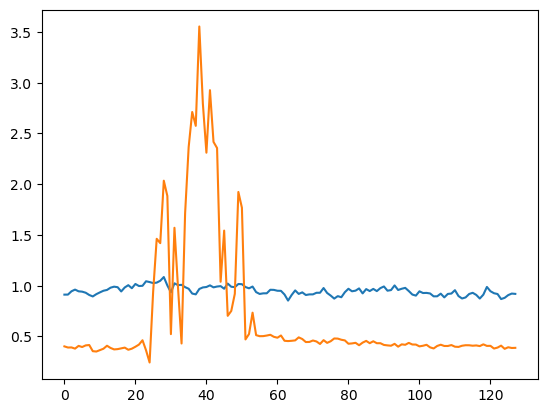

In [47]:
psi2_i = np.abs(psi_i)
psi2_f = np.abs(psi_f)
plt.plot(psi2_i)
plt.plot(psi2_f)

In [48]:
print(np.sum(np.square(np.abs(psi_i))),np.sum(np.square(np.abs(psi_f))))

115.87800265568035 115.87800265570141


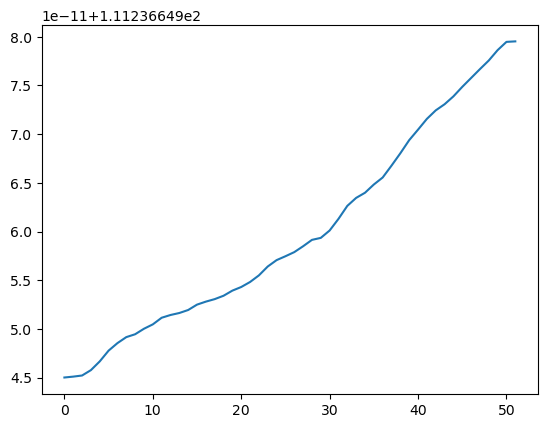

In [38]:
plt.plot(mass_l)

In [15]:
f = h5.File('test_psi_1d.h5', 'w')

d = f.create_dataset("psi_frames",data = np.array(frames))
d = f.create_dataset("mass_err",data=np.array(mass_err_l))
d = f.create_dataset("compute_time",data = comp_time)
d = f.create_dataset("da",data=(np.array(da)))


    
f.close()
print(comp_time)

0.00012111663818359375
